In [1]:
library(tidyverse)
library(kableExtra)
library(ggplot2)
options(readr.num_columns = 0)
churn <- read_csv("_build/data/churn_train.csv")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Warning message:
"package 'kableExtra' was built under R version 3.6.3"


Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



# k-Nearest Neighbors (kNN)

For many businesses, **customer churn** is an important metric for measuring customer retention. Banks, social media platforms, telecommunication companies, etc. all need to monitor customer turnover to help understand why customers leave their platform, and whether there are intervention strategies that can help prevent customer churn. 

Imagine that you work for a telecommunications provider and would like to reduce customer churn. To that end, you hope to develop a predictive model that will identify which customers are at a high risk of leaving for another provider. If you could identify these customers before they leave, you may be able to develop intervention strategies that would encourage them to stay. 

Using historical customer data that your company collected in the past quarter, you compile a data set with the account characteristics of each customer and whether or not they "churned" by the end of the previous quarter. This data is stored in a data frame called `churn`, the first few rows of which are shown below. A data dictionary which describes each variable in the data set is also provided below.

In [2]:
head(churn)

account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
165,no,no,0,209.4,67,150.2,88,12.8,1,3.46,0,no
103,no,no,0,180.2,134,181.7,134,8.4,3,2.27,1,no
90,no,yes,27,156.7,51,123.2,111,12.6,6,3.40,2,no
36,no,no,0,177.9,129,306.3,102,10.8,6,2.92,2,no
95,no,yes,35,229.1,143,248.4,110,3.9,3,1.05,0,no
119,no,no,0,231.5,82,211.0,118,7.4,10,2.00,1,no


+ `account_length`: number of months the customer has been with the provider.
+ `internation_plan`: whether the customer has an international plan.
+ `voice_mail_plan`: whether the customer has a voice mail plan.
+ `number_vmail_messages`: number of voice-mail messages.
+ `total_day_minutes`: total minutes of calls during the day.
+ `total_day_calls`: total number of calls during the day.
+ `total_night_minutes`: total minutes of calls during the night.
+ `total_night_calls`: total number of calls during the night.
+ `total_intl_minutes`: total minutes of international calls.
+ `total_intl_calls`: total number of international calls.
+ `total_intl_charge`: total charge on international calls.
+ `number_customer_service_calls`: number of calls to customer service.
+ `churn`: whether or not the customer churned. 

Our goal is to use the information stored in the `churn` data set to predict whether new customers will churn in the upcoming quarter. A straightforward way to accomplish this would be to identify the observations in `churn` that are most similar to our new customer, and then observe whether or not those customers churned in the previous period. For example, if our new customer is from the Midwest, has twenty voice mail messages, does not have an international plan, etc., we could identify the observations in `churn` that have the same (or very similar) characteristics. If the majority of those customers churned in the previous quarter, we might predict that our new customer is likely to churn; if the majority did not, we might predict that our new customer is at a low risk of churning. This is in essence how the k-nearest neighbors algorithm makes predictions.

More formally, the **k-nearest neighbors (kNN)** algorithm starts by calculating the distance between a new observation and each of the observations in `churn`. The $k$ observations that are closest to the new observation are considered its "neighbors". If most of these neighbors churned in the previous quarter, the model predicts that the new customer will churn (and vice versa). The number of neighbors that the model considers is determined by $k$, which is set by the user. $k$ is known as a **hyperparameter**, or a model parameter whose value must be specified by the user.

To demonstrate knn, let's start with a simplified data set that only has 100 observations and two independent features, `total_intl_charge` and `account_length`. Our **feature space**, or the geometric space that our data occupy, looks like the following:

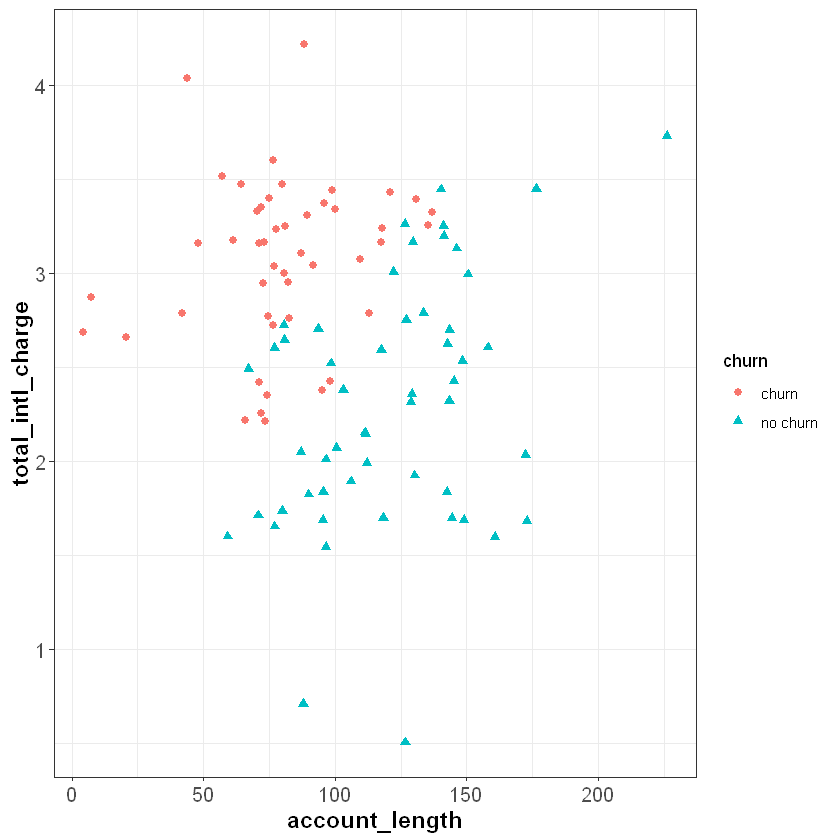

In [3]:
churnSample <- read_csv("_build/data/churn_sample.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)
library(ggplot2)

suppressMessages(print(ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=2) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))))

Suppose we have three new customers and would like to predict whether or not they will churn in the upcoming quarter. These customers are plotted as green squares in the figure below. If we use a $k$ of five, we can find the five customers in `churn` that are most similar to our new customers (based on their `account_length` and `total_intl_charge`):

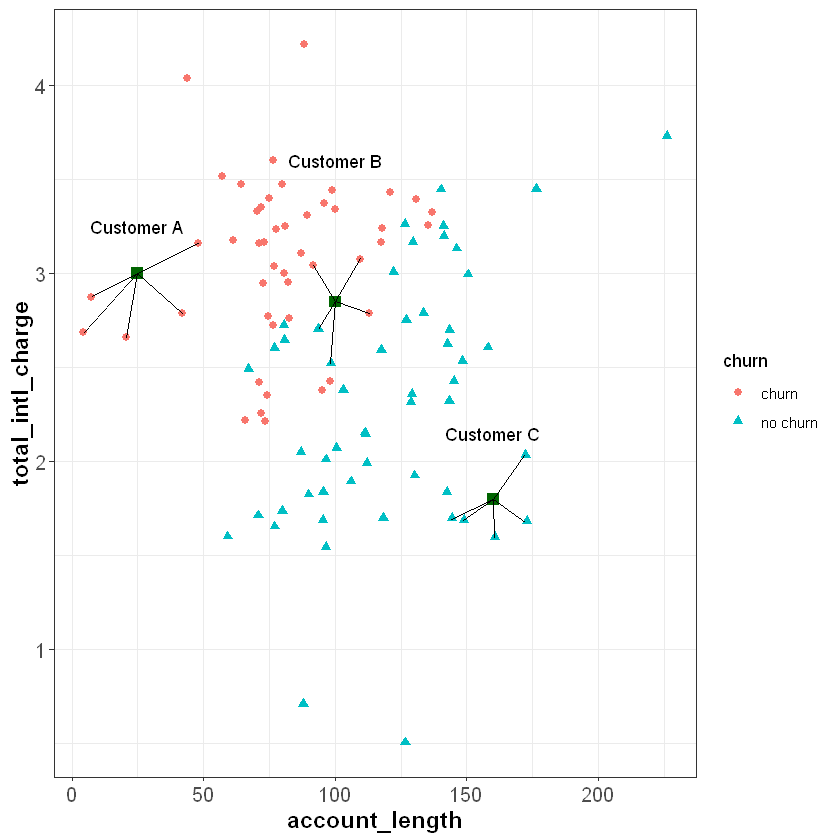

In [4]:
churnSample <- read_csv("_build/data/churn_sample.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")

churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)
library(ggplot2)

pointA = data.frame(account_length=25, total_intl_charge=3)
pointANearest = data.frame(c(4.564370,pointA$account_length,7.721684,pointA$account_length,20.697285,pointA$account_length,42.072091,pointA$account_length,48.209354, pointA$account_length), 
                           c(2.6889498,pointA$total_intl_charge,2.8776394,pointA$total_intl_charge,2.6624903,pointA$total_intl_charge,2.7909322,pointA$total_intl_charge,3.1609721,pointA$total_intl_charge),
                           c("no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn"))
names(pointANearest) = c("account_length", "total_intl_charge", "churn")
pointB = data.frame(account_length=160, total_intl_charge=1.8)
pointBNearest = data.frame(c(172.389055,pointB$account_length,171.992009,pointB$account_length,160.344819,pointB$account_length,148.586736,pointB$account_length,144.073490,pointB$account_length), 
                           c(1.6791425,pointB$total_intl_charge,2.0317458,pointB$total_intl_charge,1.5954999,pointB$total_intl_charge,1.6851977,pointB$total_intl_charge,1.6953439,pointB$total_intl_charge), c("no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn"))
names(pointBNearest) = c("account_length", "total_intl_charge", "churn")
pointC = data.frame(account_length=100, total_intl_charge=2.85)
pointCNearest = data.frame(c(93.494871,pointC$account_length,91.650732,pointC$account_length,98.252319,pointC$account_length,109.494056,pointC$account_length,112.812032,pointC$account_length),
                           c(2.7048315,pointC$total_intl_charge,3.0463884,pointC$total_intl_charge,2.5214656,pointC$total_intl_charge,3.0806561,pointC$total_intl_charge,2.7891426,pointC$total_intl_charge),
                           c("no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn","no churn"))
names(pointCNearest) = c("account_length", "total_intl_charge", "churn")

suppressWarnings(print(ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=2) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))+
  geom_point(aes(x=pointA$account_length, y=pointA$total_intl_charge), colour="darkgreen", shape=15, size=3) + annotate("text", x = 25, y = 3.25, label = "Customer A") + 
  geom_path(data=pointANearest, colour="black")+
  geom_point(aes(x=pointB$account_length, y=pointB$total_intl_charge), colour="darkgreen", shape=15, size=3) + annotate("text", x = 100, y = 3.6, label = "Customer B") + 
  geom_path(data=pointBNearest, colour="black")+
  geom_point(aes(x=pointC$account_length, y=pointC$total_intl_charge), colour="darkgreen", shape=15, size=3) + annotate("text", x = 160, y = 2.15, label = "Customer C") + 
  geom_path(data=pointCNearest, colour="black"))) 

We see that that five nearest neighbors of Customer A all churned in the previous quarter, so the algorithm would predict that Customer A will churn. Similarly, all five nearest neighbors of customer C did *not* churn in the previous quarter, so the algorithm would predict that Custer C will *not* churn. 

For Customer B, three of the nearest neighbors churned and two did *not*. Therefore, for this observation the model would predict a 60% chance of churning (3 churns / 5 neighbors = 0.60). Ultimately we need to make a binary decision about whether to intervene on this customer's account or not. To do this, we need to convert the predicted probability of 60% into a binary prediction of "churn" or "no churn". Because the predicted chance of churning is greater than 50%, the model is predicting that it is more likely than not that the customer will churn. Therefore, one may choose to treat this as a prediction of "churn". In this case, we have used a cutoff of 50% to convert the model's prediction into a binary outcome; if the predicted probability is less than 50% we interpret the prediction as "no churn", and if it is greater than 50% we interpret it as "churn".

Although 50% seems like a natural cutoff, consider the following scenario. Suppose that when our model predicts a customer will churn, we offer that customer a very large discount to convince them to stay with the service. Because this discount is so costly, we only want to offer it to customers when we are very confident that they will churn in the upcoming quarter. If this were the case, we may want to be more than 50% confident before we intervene. For example, we may choose to intervene only if the model is 80% or more confident that the customer will churn in the next quarter. In this scenario, we would apply a cutoff of 80% instead of 50%. This is an example of how managerial judgment is an important component of any data science project. Without understanding the costs of an intervention (and the relative benefit of retaining customers), it would be difficult to find the optimum cutoff to apply to the model's predictions.

## Calculating Distance

So far we have not discussed how the model calculates the distance between observations. It turns out that there are several different ways to calculate distance, and each method has its own advantages (*see* [here](https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html) for more information). Here we will only cover the most basic distance measure, called Euclidean distance. However, be aware that there are other methods that may be useful depending on the context of the problem.

The **Euclidean distance** between two points is simply the distance between those points in Euclidean space. Let's say we want to calculate the Euclidean distance between Customer A and one of their neighbors:

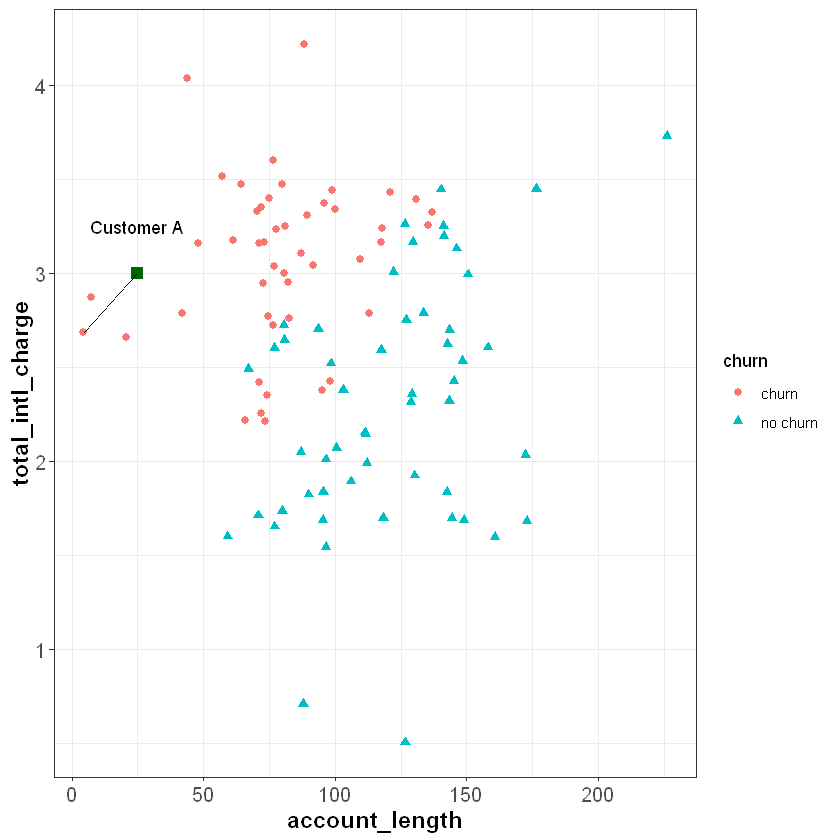

In [5]:
churnSample <- read_csv("_build/data/churn_sample.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")

churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)
library(ggplot2)

pointA = data.frame(account_length=25, total_intl_charge=3)
pointANearest = data.frame(c(4.564370,pointA$account_length), 
                           c(2.6889498,pointA$total_intl_charge),
                           c("no churn","no churn"))
names(pointANearest) = c("account_length", "total_intl_charge", "churn")

suppressWarnings(print(ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=2) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))+
  geom_point(aes(x=pointA$account_length, y=pointA$total_intl_charge), colour="darkgreen", shape=15, size=3) + annotate("text", x = 25, y = 3.25, label = "Customer A") + 
  geom_path(data=pointANearest, colour="black")))

For two points ($x_1$, $y_1$) and ($x_2$, $y_2$), the Euclidean distance between them is calculated as:

$$
\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

The coordinates for Customer A are (25, 3), and the coordinates for the other point are (4.56, 2.69). Applying the formula above, we can calculate the distance between them as:


$$
\sqrt{(4.56 - 25)^2 + (2.69 - 3)^2} \approx 20.44
$$

The larger this value, the further away the two points are in Euclidean space. Therefore, the kNN algorithm finds the $k$ observations with the smallest Euclidean distance from the new observation. Note that although we are currently working in two dimensions, this formula can be extended to higher dimensions when we are working with more than two independent features.

## Normalizing Data

If you review the plot from the previous section, you will notice that the $x$ and $y$ axes are on very different scales. The `account_length` variable ranges from around zero to over 200, while `total_intl_charge` ranges from from about two to four. This is problematic for the calculation of Euclidean distance, because the distance between points is impacted by the magnitude of each variable.

For example, imagine two observations with the same `total_intl_charge` but a different `account_length`: (50, 2) and (100, 2). The Euclidean distance between these observations would be:

$$
\sqrt{(100 - 50)^2 + (2 - 2)^2} = \sqrt{(50)^2} = 50
$$
Now imagine two observations with the same `account_length` but a different `total_intl_charge`: (150, 2) and (150, 3). The Euclidean distance between these observations would be:

$$
\sqrt{(150 - 150)^2 + (3 - 2)^2} = \sqrt{(1)^2} = 1
$$

If we plot these points in our feature space, they seem to be roughly the same distance from each other. However, they have very different Euclidean distances. The reason for this is that `account_length` is measured on a greater scale than `total_intl_charge`, so it has a greater impact the distance metric.

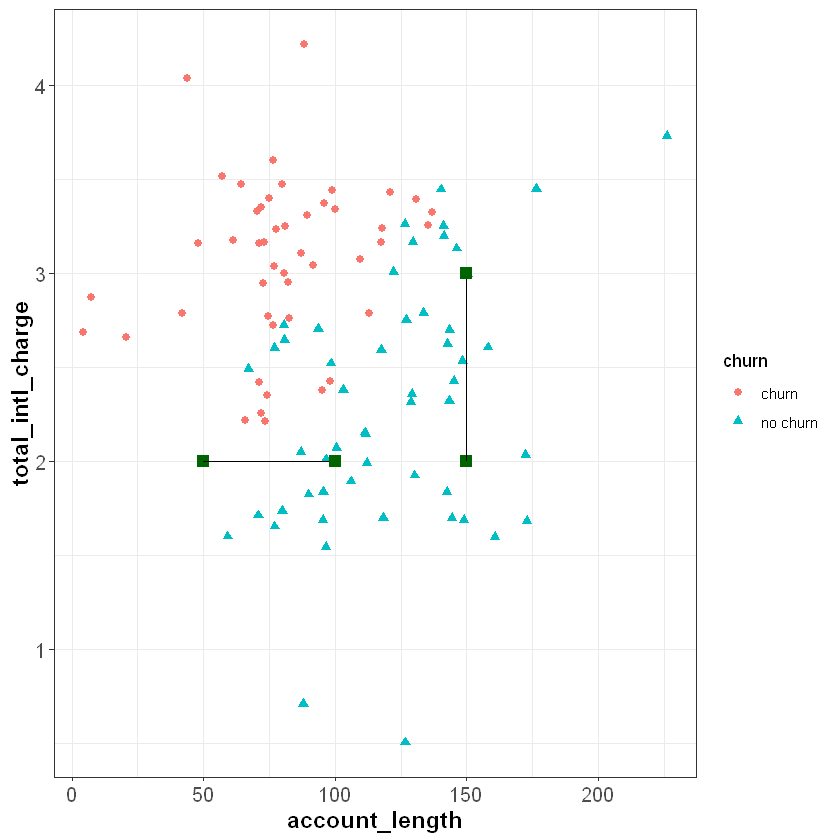

In [6]:
churnSample <- read_csv("_build/data/churn_sample.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")

churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)
library(ggplot2)

pointA = data.frame(account_length=50, total_intl_charge=2,churn="churn")
pointB = data.frame(c(100,pointA$account_length), 
                           c(2,pointA$total_intl_charge),
                           c("no churn","no churn"))
names(pointB) = c("account_length", "total_intl_charge", "churn")

pointC = data.frame(account_length=150, total_intl_charge=2,churn="churn")
pointD = data.frame(c(150,pointC$account_length), 
                           c(3,pointC$total_intl_charge),
                           c("no churn","no churn"))
names(pointD) = c("account_length", "total_intl_charge", "churn")

suppressWarnings(print(ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=2) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))+
  geom_point(aes(x=pointA$account_length, y=pointA$total_intl_charge), colour="darkgreen", shape=15, size=3) +
  geom_path(data=pointB, colour="black") + 
  geom_point(aes(x=pointB[1,]$account_length, y=pointB[1,]$total_intl_charge), colour="darkgreen", shape=15, size=3)+
  geom_point(aes(x=pointC$account_length, y=pointC$total_intl_charge), colour="darkgreen", shape=15, size=3) +
  geom_path(data=pointD, colour="black") + 
  geom_point(aes(x=pointD[1,]$account_length, y=pointD[1,]$total_intl_charge), colour="darkgreen", shape=15, size=3)))

When applying the kNN algorithm, we want to eliminate the impact of magnitude on the distance between points. One common method to accomplish this is to **normalize** the data so that each variable is measured on the same scale. A common method of normalization is **min-max scaling**, which converts each variable to the range [0, 1]. For a given variable $x$, the formula for min-max scaling is:

$$
x' = \frac{x - min(x)}{max() - min(x)}
$$

If we apply this process to our data set, our feature space will look the same, but `account_length` and `total_intl_charge` will both be in the range [0, 1]:

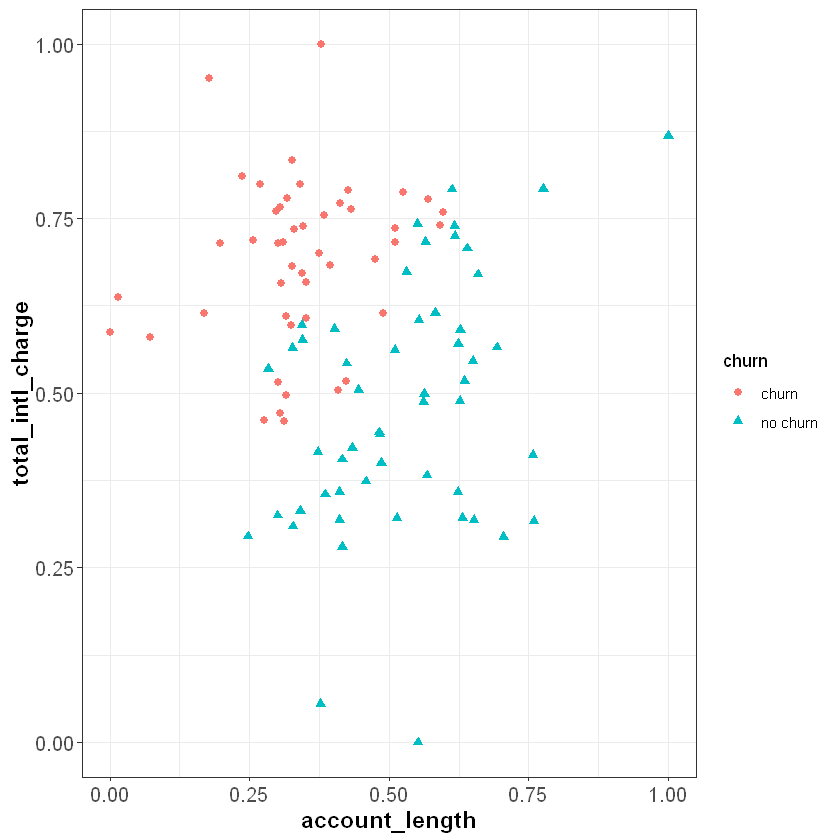

In [7]:
churnSample <- read_csv("_build/data/churn_sample.csv")
churnSample$account_length <- (churnSample$account_length - min(churnSample$account_length)) / (max(churnSample$account_length) - min(churnSample$account_length))
churnSample$total_intl_charge <- (churnSample$total_intl_charge - min(churnSample$total_intl_charge)) / (max(churnSample$total_intl_charge) - min(churnSample$total_intl_charge))
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
library(ggplot2)

suppressWarnings(print(ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=2) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))))

Now when we calculate Euclidean distance *after* applying min-max normalization, the scale that each variable is measured on will not impact the distance metric.

## Applying kNN in R

Now that we understand how the kNN algorithm works, let's see how it can be applied to our `churn` data set in R. 

Instead of working with just `account_length` and `total_intl_charge`, we will now work with all relevant features in our data set. As we saw in the previous section, the first thing to do is normalize the continuous variables in the data set so that they are on the same scale. We can apply min-max scaling with the `preProcess()` function from the `caret` package, which uses the following syntax:

```{admonition} Syntax
`caret::preProcess(x, method = c("center", "scale"))`
+ *Required arguments*
  - `x`: A data frame with the variables to scale. 
+ *Optional arguments*
  - `method`: Used to specify the desired type of preprocessing. To apply min-max scaling, this can be set to "range".
```  
  
This function creates an object (which we call `scaler` below) that we can then pass in to `predict()` to scale our data set. As you can see, the continuous variables in `churnScaled` are all in the range [0,1]. Note also that `preProcess()` knows to ignore non-continuous variables (*e.g.*, `international_plan`), which do not need to be normalized.

In [8]:
library(caret)

# Create min-max scaler
scaler <- preProcess(churn, method="range")

# Apply scaler to our data set
churnScaled <- predict(scaler, churn)

Loading required package: lattice



Attaching package: 'caret'



The following object is masked from 'package:purrr':

    lift



In [9]:
head(churnScaled)

account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0.6776860,no,no,0.00,0.5957326,0.4060606,0.3802532,0.5176471,0.640,0.05,0.6407407,0.0000000,no
0.4214876,no,no,0.00,0.5126600,0.8121212,0.4600000,0.7882353,0.420,0.15,0.4203704,0.1111111,no
0.3677686,no,yes,0.54,0.4458037,0.3090909,0.3118987,0.6529412,0.630,0.30,0.6296296,0.2222222,no
0.1446281,no,no,0.00,0.5061166,0.7818182,0.7754430,0.6000000,0.540,0.30,0.5407407,0.2222222,no
0.3884298,no,yes,0.70,0.6517781,0.8666667,0.6288608,0.6470588,0.195,0.15,0.1944444,0.0000000,no
0.4876033,no,no,0.00,0.6586060,0.4969697,0.5341772,0.6941176,0.370,0.50,0.3703704,0.1111111,no


<br>

Next, we need to convert the categorical features in our data set to numeric dummy variables. If you recall from Section [Dummy Variables](dummy.html#dummy-variables), the `lm()` and `glm()` functions automatically convert categorical variables to binary dummy variables when one is using linear or logistic regression. Unfortunately, the function we will use for kNN does *not* do this automatically, so we need to do it ourselves.

In [10]:
# Convert categorical variables to dummy variables
churnScaled$international_plan <- ifelse(churnScaled$international_plan=="yes", 1, 0)
churnScaled$voice_mail_plan <- ifelse(churnScaled$voice_mail_plan=="yes", 1, 0)

In [11]:
head(churnScaled)

account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0.6776860,0,0,0.00,0.5957326,0.4060606,0.3802532,0.5176471,0.640,0.05,0.6407407,0.0000000,no
0.4214876,0,0,0.00,0.5126600,0.8121212,0.4600000,0.7882353,0.420,0.15,0.4203704,0.1111111,no
0.3677686,0,1,0.54,0.4458037,0.3090909,0.3118987,0.6529412,0.630,0.30,0.6296296,0.2222222,no
0.1446281,0,0,0.00,0.5061166,0.7818182,0.7754430,0.6000000,0.540,0.30,0.5407407,0.2222222,no
0.3884298,0,1,0.70,0.6517781,0.8666667,0.6288608,0.6470588,0.195,0.15,0.1944444,0.0000000,no
0.4876033,0,0,0.00,0.6586060,0.4969697,0.5341772,0.6941176,0.370,0.50,0.3703704,0.1111111,no


<br>

Now that we have prepared the data set we will use to build the model (`churnedScaled`), let's prepare the data set with the observation we would like to make a prediction on. Suppose we have a file called `"churn_new.csv"` that contains the information of a new customer, and we would like to predict whether that customer will churn in the next quarter.

In [12]:
churnNew <- read_csv("_build/data/churn_new.csv")

In [13]:
head(churnNew)

account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
12,no,no,0,250,118,280,90,11.8,3,3.19,1


<br>

As with our other data set, we need to (1) normalize the variables, and (2) convert the categorical variables into dummies. To normalize the data, we can apply the `scaler` object that we created above. To do this we can now just pass `scaler` and `churnNew` into `predict()`. This will apply the min-max formula to `churnNew` based on the minimum and maximum values used to create `churnScaled`.

In [14]:
churnNewScaled <- predict(scaler, churnNew)

In [15]:
head(churnNewScaled)

account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0.04545455,no,no,0,0.7112376,0.7151515,0.7088608,0.5294118,0.59,0.15,0.5907407,0.1111111


<br>

Next, we need to convert our categorical variables into dummies:

In [16]:
churnNewScaled$international_plan <- ifelse(churnNewScaled$international_plan=="yes", 1, 0)
churnNewScaled$voice_mail_plan <- ifelse(churnNewScaled$voice_mail_plan=="yes", 1, 0)

In [17]:
head(churnNewScaled)

account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0.04545455,0,0,0,0.7112376,0.7151515,0.7088608,0.5294118,0.59,0.15,0.5907407,0.1111111


<br>

Now that our data has been processed, we can actually apply the kNN algorithm! We can do this in R with the `knn()` function from the `class` package, which uses the following syntax:

```{admonition} Syntax
`class::knn(train, test, cl, k = 1, prob = FALSE)`
+ *Required arguments*
  - `train`: A data frame with the observations used to build the model. This should only contain the independent ($X$) features, not the target feature ($Y$).
  - `test`: A data frame with the observation(s) the model should be applied to. 
  - `cl`: A vector with the correct labels ($Y$) of the observations used to build the model.
+ *Optional arguments*
  - `k`: The number of nearest neighbors considered.
  - `prob`: Whether or not the probability of each prediction is returned. If `prob` equals `FALSE`, the function returns a binary prediction (*e.g.* "churn" or "no churn"). 
```  
  
Below we apply this function, with `churnScaled` used to build the model and `churnNewScaled` used to make predictions. Note that the `train` parameter only accepts the $X$ features (and not the target feature $Y$), so we exclude the thirteen column in `churnScaled` when passing the data to `train`.

In [18]:
library(class)
knnModelK5 <- knn(train = churnScaled[,-13], test = churnNewScaled, 
                  cl = churnScaled$churn, k = 5, prob=TRUE)

knnModelK5

[1] no
attr(,"prob")
[1] 0.8
Levels: no yes

Based on this output, our model predicts that the new customer will *not* churn.